# Свёртка и свёрточные нейронные сети

## Свёртка

<b>Свёртка</b> — операция в функциональном анализе, которая при применении к двум функциям $f$ и $g$ возвращает третью функцию, соответствующую взаимнокорреляционной функции $f(x)$ и $g(-x)$. Операцию свёртки можно интерпретировать как «схожесть» одной функции с отражённой и сдвинутой копией другой.

### Одномерная свёртка

Подобно кросскорреляции, свёртка может быть использована для анализа сходства двух сигналов с разными запаздываниями.  

Существует множество применений свертки. Она особенно популярна в обработке изображений и машинном зрении, где свертка используется для обнаружения (подчёркивания) границ и подобных приложений. Свертка входного сигнала и импульсного отклика дает на выходе линейную инвариантную во времени систему. Это делает ее очень распространенной операцией в электротехнике. Ниже показана свёртка треугольного и прямоугольного импульса.

![SegmentLocal](images/1dconvolution.gif "segment")

Свёртка определяется как интеграл произведения двух сигналов (функций), где один из сигналов обращен во времени. Она тесно связана с кросс-корреляцией. Фактически, это кросс-корреляция после того, как один из сигналов был изменен на противоположный.

Определение довольно простое, вы накладываете два сигнала с заданной задержкой и коррелируете с запаздывающим сигналом в обратном порядке. То есть, один из сигналов меняется на противоположный.

В общем случае, свёртка определена так:

$$(f * g)(t) = f(x) * g (x, t) $$

$$(f * g)(t) = \int\limits_{-\infty}^\infty f(x)g(t-x)dx $$

Математическая запись для случая дискретных сигналов:

$$(f * g)[n] = \sum\limits_{k\to-\infty}^\infty f[k] \cdot g[n-k] $$

Свёртку ещё часто записывают в виде интегрального преобразования с некоторым ядром (kernel) $K$:
$$(\mathrm{T} f)(t) = \int\limits_{-\infty}^\infty f(x)K(t, x)dx $$


Рассмотрим примеры реализации свёрток

In [172]:
def sig_square(x):
  return 0 if x < 3 or x > 5 else 2

def sig_triag(x):
  return 0 if x < 0 or x > 2 else x

# Первый сигнал: прямоугольный импульс
sig1 = [sig_square(x/100) for x in range(1000)]

# Второй сигнал: треугольный импульс
sig2 = [sig_triag(x/100) for x in range(200)]

Реализация на "чистом" Python может выглядеть так:

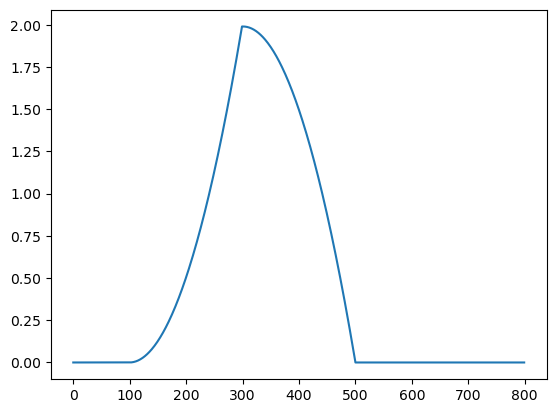

In [173]:
import matplotlib.pyplot as plt

# Здесь будет результат
conv = (len(sig1) - len(sig2)) * [0]

# Проходим по всем запаздывающим компонентам
for l in range(len(conv)):
  for i in range(len(sig2)):
    conv[l] += sig1[l-i+len(sig2)] * sig2[i]

# Нормализуем результат
  conv[l] /= len(sig2) 

plt.plot(conv)

Все популярные математические библиотеки (в том числе, NumPy и SciPy) имеют функции для реализации свёртки, поэтому писать циклы не нужно! (К тому же, векторизованные варианты быстрее)

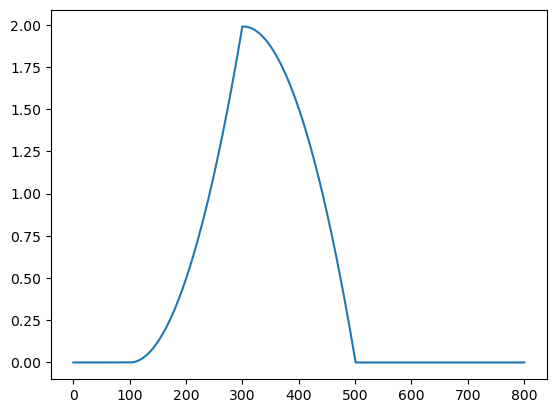

In [174]:
import numpy as np

# Свернули
conv = np.convolve(sig1, sig2, mode='valid')

# Нормализовали
conv /= len(sig2)

# Нарисовали
plt.plot(conv)

В связи с тем, что один из сигналов берётся с лагом, существует 3 типа операций свёртки:
1. С дополнением (padding), полная (full)
2. С дополнением (padding), идентичная (same)
3. Без дополнения, "правильная" (valid)

<b>1. Cвёртка с полным дополнением (padding, full).</b>
При вычислении свёртки исходный сигнал дополняется по краям необходимым количеством нулей. В этом случае результат будет большим по размеру, чем исходный сигнал

In [175]:
import numpy as np

x = [6, 2]
h = [1, 2, 5, 4]

y = np.convolve(x, h, "full")
y  

array([ 6, 14, 34, 34,  8])

<b>2. Cвёртка с "идентичным" дополнением (padding, same).</b> При вычислении свёртки сигнал дополняется только с одной стороны нулями. Свойство этого варианта свёртки: сигнал на выходе будет иметь размер аналогичный сигналу на входе.

In [176]:
import numpy as np

x = [6, 2]
h = [1, 2, 5, 4]

y = np.convolve(x, h, "same")
y  

array([ 6, 14, 34, 34])

<b>3. "Правильная" свёртка, без дополнения.</b> При вычислении свёртки сигнал никак не дополняется, вычисления производятся только тогда, когда есть все данные, так что искажения не вносятся. Однако, выходной сигнал будет обрезан.

In [177]:
import numpy as np

x = [6, 2]
h = [1, 2, 5, 4]

y = np.convolve(x, h, "valid")
y  

array([14, 34, 34])

Одномерная свёртка может применяться для:
* фильтрации
* детектирования сигналов
* анализа временных рядов

### Двумерная свёртка

Двумерная свётрка имеет те же свойства и определение, что и одномерная, но для случая двумернах сигналов. Самые распространённые двумерные сигналы - это изображения.

Существуют и используются те же самые типы свёртки, что и в одномерном случае (full, same, valid).

Пусть дано полутоновое изображение, определённое матрицей яркостей пикселей $I$. Тогда двумерная дискретная свёртка изображения $I$ и фильтра $g$ будет задано следующим образом:

<font size="4">$$ I'= \sum\limits_{u,v} I(x-u,y-v)g(u,v) $$ </font> 
 
 
Рассмотрим на примере применение свёртки к матрице изображения 3x3 в случае ядра свёртки g = (-1 1). Когда применяем ядро, всегда используем его инверсию. Ниже показаны все вычисления пошагово.
 
$
I=
\begin{bmatrix}
     255          & 7      & 3     \\
     212          & 240    & 4     \\
     218          & 216    & 230
\end{bmatrix}
\\
$ 

$
g=
\begin{bmatrix}
     -1          & 1      
\end{bmatrix}
\\
$ 
  
$
\begin{bmatrix}
    \textbf{1}\cdot \textbf{0}      & \textbf{-1} \ast \textbf{255}  & 7      & 3     \\
    0              & 212          & 240    & 4     \\
    0              & 218          & 216    & 230
\end{bmatrix}
\rightarrow
\begin{bmatrix}
    \textbf{-255}  & 7      & 3     \\
    212            & 240    & 4     \\
    218            & 216    & 230
\end{bmatrix}
\\
$

$
\begin{bmatrix}
    \textbf{1}\ast \textbf{255}      & \textbf{-1} \ast \textbf{7}  & 3    \\
    212          & 240    & 4     \\
    218          & 216    & 230
\end{bmatrix}
\rightarrow
\begin{bmatrix}
    -255           & \textbf{248}      & 3     \\
    212            & 240    & 4     \\
    218            & 216    & 230
\end{bmatrix}
\\
$

$
\begin{bmatrix}
    255          & \textbf{1}\ast\textbf{7}  & \textbf{-1}\ast\textbf{3}    \\
    212          & 240    & 4     \\
    218          & 216    & 230
\end{bmatrix}
\rightarrow
\begin{bmatrix}
    -255           & 248      & \textbf{4}     \\
    212            & 240      & 4     \\
    218            & 216      & 230
\end{bmatrix}
\\
$

  
$
\begin{bmatrix}
    0              & 255          & 7          & 3     \\
    \textbf{1}\ast \textbf{0}    & \textbf{-1} \ast \textbf{212}  & 240     & 4     \\
    0              & 218          & 216    & 230
\end{bmatrix}
\rightarrow
\begin{bmatrix}
    \textbf{-255}  & 248    & 4     \\
    -212            & 240    & 4     \\
    218            & 216    & 230
\end{bmatrix}
\\
$
 

In [178]:
from scipy import signal as sg

I= [[255,   7,  3],
    [212, 240,  4],
    [218, 216, 230]]

g= [[-1, 1]]
 
print('Без дополнения \n')
print('{0} \n'.format(sg.convolve( I, g, 'valid')))

print('С дополнением нулями до полноты \n')
print('{0} \n'.format(sg.convolve( I, g, 'full')))

print('С дополнением нулями для получения идентичного размера \n')
print('{0} \n'.format(sg.convolve( I, g, 'same')))

Без дополнения 

[[248   4]
 [-28 236]
 [  2 -14]] 

С дополнением нулями до полноты 

[[-255  248    4    3]
 [-212  -28  236    4]
 [-218    2  -14  230]] 

С дополнением нулями для получения идентичного размера 

[[-255  248    4]
 [-212  -28  236]
 [-218    2  -14]] 



In [179]:
# Чуть более сложный случай, с двумерным ядром

I= [[255,   7,  3],
    [212, 240,  4],
    [218, 216, 230]]

g= [[-1,  1],
    [ 2,  3]]

print ('С полным нулевым дополнением \n')
print ('{0} \n'.format(sg.convolve( I, g, 'full')))

print ('С нулевым дополнением для идентичного размера \n')
print ('{0} \n'.format(sg.convolve( I, g, 'same')))

print ('Без нулевого дополнения \n')
print (sg.convolve( I, g, 'valid'))

С полным нулевым дополнением 

[[-255  248    4    3]
 [ 298  751  263   13]
 [ 206 1118  714  242]
 [ 436 1086 1108  690]] 

С нулевым дополнением для идентичного размера 

[[-255  248    4]
 [ 298  751  263]
 [ 206 1118  714]] 

Без нулевого дополнения 

[[ 751  263]
 [1118  714]]


### Применение 2D-свёртки в обработке изображений

Свёртка позволяет реализовать фильтрацию изображения с различными фильтрами.

На приведенном ниже изображении с помощью анимации можно увидеть, как операция двумерной свертки будет работать с изображениями. Эта операция выполняется в большинстве фреймворков глубокого обучения. Для создания свернутой матрицы нам нужны скользящие окна:


$
kernel=
\begin{bmatrix}
     1          & 0      & 1     \\
     0          & 1    & 0     \\
     1          & 0    & 1
\end{bmatrix}
\\
$ 


Скользящее окно (ядро, фильтр или детектор свойств) с заданными параметрами вычислений ([[x1, x0,x1], [x0,x1,x0], [x1,x0,x1]]) проходит по всему изображению и в результате создаёт новую матрицу - <b>карту свойств</b>.

![SegmentLocal](images/conv-process.gif "segment")

Значения из фильтра поэлементно умножались на исходную матрицу (входное изображение), затем суммировались. Чтобы получить полную свернутую матрицу, алгоритм повторяет эту небольшую процедуру для каждого элемента, скользя фильтром по всей исходной матрице.

<img src="images/pixel-res.png" alt="One pixel calculation" style="width: 400px; height: 200px;">

Как и в приведенном примере, одномерную свертку можно представить как скользящую функцию (фильтр 1x1 или 1x2), умножающую и складывающую поверх массива (одномерного массива, вместо исходной матрицы).

Попробуем применить к реальному изображению фильтр с одинаковыми весами, показанный на рисунке. Вот, что получилось из этого:

<img src="images/taj.png" alt="Blurring" style="width:700px;height:350px;">

Как видно из рисунка, свёртка изображения с маской, показанной слева, приводит к его размытию. Это связано с усредняющим эффектом свёртки. Если же взять другой фильтр, то можно получить иной эффект.

<img src="images/taj-edge.png" alt="Blurring" style="width:700px;height:350px;">

Как мы видим из примера, на изображении подчёркнуты границы.


 Тип оригинального изображения: <PIL.Image.Image image mode=L size=600x512 at 0x1F474B43370> 


После преобразования в числовой формат: 

 array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

 Входное изображение, конвертированное в полутоновое: 



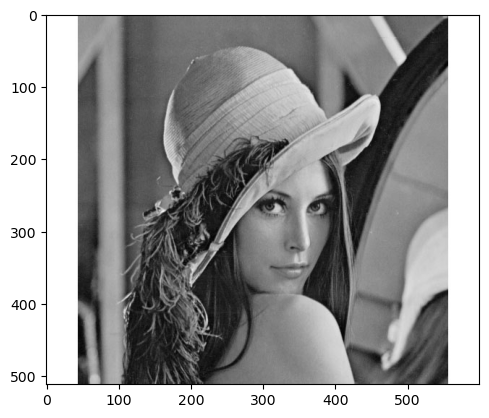

In [180]:
import numpy as np
from scipy import signal
from scipy import misc
import matplotlib.pyplot as plt
from PIL import Image

im = Image.open('images/lena.jpg')
# Конвертируем цветное в полутоновое, используя преобразование ITU-R 601-2 Luma
image_gr = im.convert("L")

print("\n Тип оригинального изображения: %r \n\n" % image_gr)
arr = np.asarray(image_gr)
print("После преобразования в числовой формат: \n\n %r" % arr)
%matplotlib inline

imgplot = plt.imshow(arr)
imgplot.set_cmap('gray')
print("\n Входное изображение, конвертированное в полутоновое: \n")
plt.show(imgplot)

Теперь попробуем свернуть изображение с ядром детектора границ.

In [181]:
kernel = np.array([[ 0, 1, 0],
                   [ 1,-4, 1],
                   [ 0, 1, 0],]) 

grad = signal.convolve2d(arr, kernel, mode='same', boundary='symm')

Амплитуда градиента, вычисленная свёрткой (карта признаков)


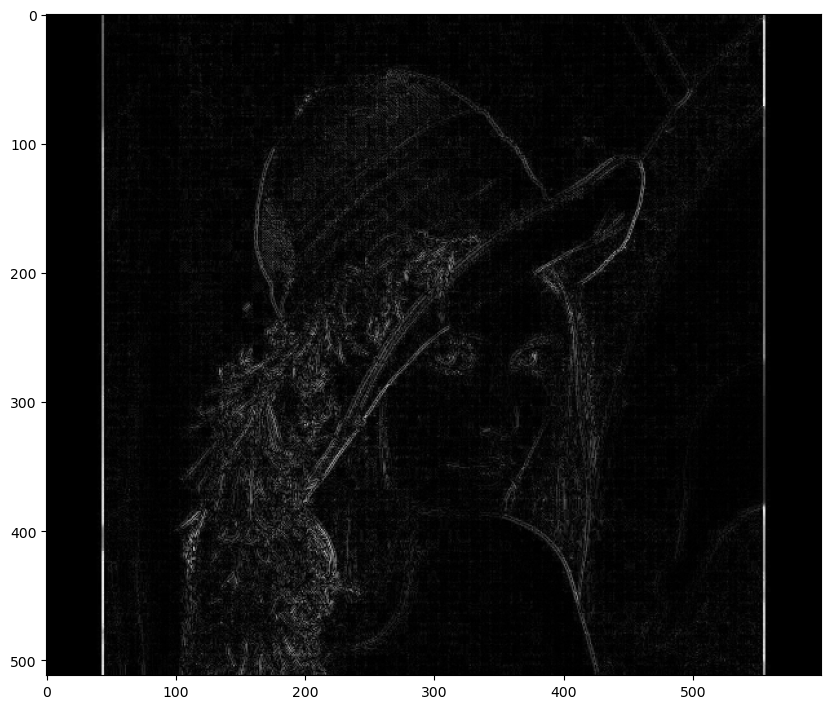

In [182]:
print('Амплитуда градиента, вычисленная свёрткой (карта признаков)')

fig, aux = plt.subplots(figsize=(10, 10))
aux.imshow(np.absolute(grad), cmap='gray')

<b>Если мы изменим ядро и начнем анализировать выходы, мы будем действовать как свёрточная нейросеть.</b> Разница в том, что нейронная сеть делает всю эту работу автоматически (настройка ядра с помощью различных весов). Кроме того, мы можем понять, как смещения влияют на поведение карт признаков.

In [183]:
type(grad)

grad_biases = np.absolute(grad) + 150

grad_biases[grad_biases > 255] = 255

Новая карта признаков


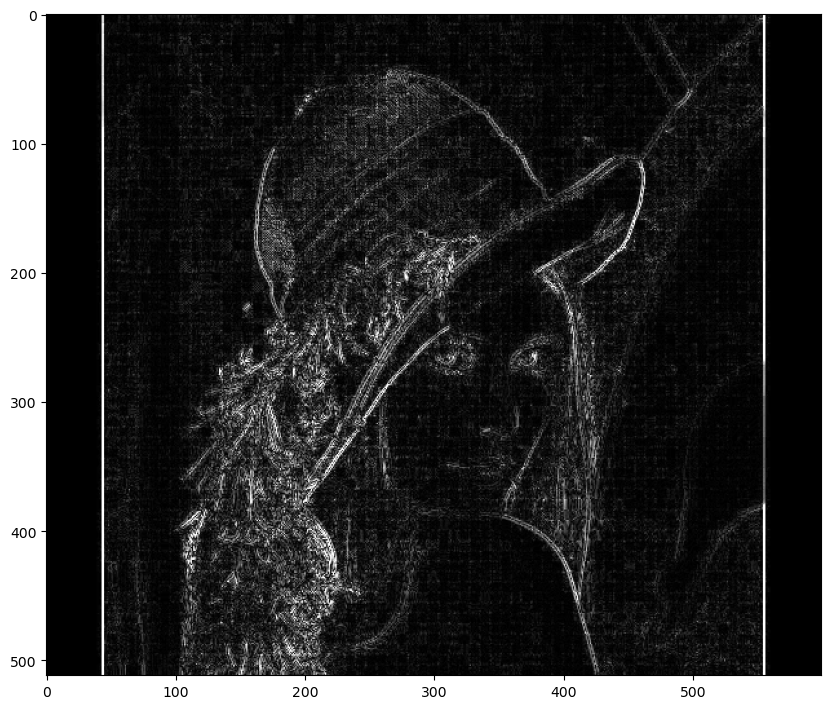

In [184]:
%matplotlib inline

print('Новая карта признаков')

fig, aux = plt.subplots(figsize=(10, 10))
aux.imshow(np.absolute(grad_biases), cmap='gray')

## <span style="color: #f0f">Задание 1</span>

1. Из папки images загрузите изображение 'operator.png'. Выполните свёртку этого изображения с различными фильтрами, которые позволят сделать следующее:
- Выделить только вертикальные границы
- Выделить только горизонтальные границы
- Выделить диагональные границы, идущие из северо-западного угла в юго-восточный.

Фильтры постройте самостотельно и поясните, почему использовали именно такие коэффициенты.

2. Попробуйте несколько раз подряд выполнить свёртку изображения с фильтром размером 3х3, в котором все коэффициенты равны 1. Визуализируйте промежуточные результаты и объясните их.

## Свёрточные нейронные сети

### Основы и предпосылки

<b>Свёрточные нейронные сети (CNN, ConvNet)</b> очень похожи на обычные нейронные сети. Они состоят из нейронов, которые имеют обучаемые веса и смещения. Вся сеть по-прежнему выражает единственную дифференцируемую функцию оценки: от необработанных пикселей изображения на одном конце до оценок принадлежности к определённому классу на другом. И у них по-прежнему есть функция потерь (например, SVM/Softmax) на последнем (полностью подключенном) слое, поэтому большинство из сказанного ранее о нейросетях, по-прежнему применимо.

Обычные нейронные сети не очень хорошо масштабируются на полные изображения. Для набора данных изображений CIFAR-10 изображения имеют размер 32x32x3 (32 в ширину, 32 в высоту, 3 цветовых канала), поэтому один полностью подключенный нейрон в первом скрытом слое обычной нейронной сети будет иметь <b>32x32x3 = 3072 веса!</b>. Это количество все еще кажется приемлемым, но очевидно, что эта полностью связанная структура не подходит для больших изображений. Например, изображение более солидного размера, например, 200x200x3, привело бы к нейронам, имеющим 200x200x3 = 120 000 весов. Более того, нам почти наверняка понадобится многослойная сеть, так что число этих параметров будут быстро увеличиваться! <b>Очевидно, что такая полная связность является расточительной, а огромное количество параметров быстро приведет к переобучению</b>.

Таким образом, в отличие от обычной нейронной сети, в архитектуре ConvNet <b>делается явное предположение, что входными данными, в первую очередь, являются изображения</b>, что позволяет нам закодировать определенные свойства в архитектуре. Это значительно сокращает количество параметров в сети. В более явном виде слои сети ConvNet состоят из нейронов, расположенных в трех измерениях: ширина, высота, глубина. (Обратите внимание, что слово глубина здесь относится к третьему измерению активационного объема, а не к глубине полной нейронной сети, которая может относиться к общему количеству слоев в сети). Например, входные изображения в CIFAR-10 представляют собой входные объемы 32x32x3 (ширина, высота, глубина соответственно).

Для построения архитектур ConvNet мы используем три основных типа слоев: 
- свёрточный слой
- слой субдискретизации (poolong)
- уже знакомы нам полносвязный слой (точно так же, как в обычных нейронных сетях).

Свёрточная нейронная сеть, как правило, сочетает в себе все эти слои.

P.S.: несмотря на изначально предполагаемую обработку изображений, свёрточные сети широко применяются в задачах прогнозирования временных рядов, NLP и даже могут решать некоторые классические задачи машинного обучения.

### 2D свёрточные слои в нейронных сетях

Какждый 2D-слой свёрточной сети представляет собой банк фильтров. Размер этого банка f1xf2xc, где f1 и f2 - ширина и высота фильтра, а c - количество фильтров. Как правило, фильтры квадратные и f1=f2=f.

Предположим, что мы будем подавать на вход данные их набора CIFAR. В этом случае входное изображение будет иметь следующий вид:

<img src="images/conv1.png" width="30%" height="30%">

32х32 - это размер изображения, а третья размерность обозначает количество цветовых каналов (RGB).
В свёрточной нейронной сети свёртка будет осуществляться с применением банков фильтров, например, 3х3 или 5х5 (могут использоваться и другие, большие, размеры). Однако, <b>глубина фильтров в банке должна совпадать с количеством цветовых каналов!</b>

<img src="images/conv2.png" width="80%" height="80%">

Свёртка означает, что мы берем фильтр и начинаем скользить им по всем возможным пространственным расположениям входного сигнала от левого верхнего угла до правого нижнего. Этот фильтр представляет собой набор весов, т.е. 5x5x3=75 весов + 1 смещение = 76 параметров в целом (веса фильтра являются параметрами, которые обучаются на этапе обратного распространения). В каждой позиции взвешенная сумма пикселей рассчитывается как $W^TX + b$ и получается новое значение.

Обычно используется несколько фильтров (каждый из которых независим друг от друга). Поэтому, если используется 10 фильтров (число - это гиперпараметр, который мы можем и должны настраивать), результат будет выглядеть следующим образом:

<img src="images/conv3.png">

### Размеры карт активации

Вы могли заметить, что на выходе мы получили блок размером 28×28, когда на входе было 32×32. Почему так? Давайте рассмотрим более простой случай. Предположим, что исходное изображение имеет размер 6x6xd, а фильтр имеет размер 3x3xd. Поскольку размер глубины входного изображения и фильтра всегда одинаков, мы можем рассматривать его только с точки зрения вида сверху вниз (без учета глубины).

<img src="images/conv4.png" width="90%" height="90%">

Определим общий случай, когда изображение имеет размерность $N \times N \times d$ а фильтр $F \times F \times d$. Также определим еще один гиперпараметр **stride (S)**, который представляет собой количество ячеек (в матрице выше) для перемещения на каждом шаге. У нас страйд был равен 1, но он может быть и большим. Учитывая эту информацию, размер вывода можно вычислить по следующей формуле:

$$(N – F)/S + 1$$

Если учесть возможное дополнение (padding) по краям изображения, например, при 'same' свёртке, то в общем виде формула будет иметь следующий вид:

$$(N−F+2P)/S+1$$,

где P - это размер дополнения (padding).

### Слои субдискретизации (pooling)

Мы используем дополнение в слое свертки для сохранения размера входных данных. Слои субдискретизации, наоборот, используются для УМЕНЬШЕНИЯ размера входных данных. Они отвечают за понижение дискретизации сети, чтобы сделать ее более управляемой. Наиболее распространенной формой выполнения понижающей выборки является max-pooling.

Рассмотрим следующий слой 4×4. Если мы используем фильтр 2×2 с шагом 2 и max-pooling, то получим следующий результат:

<img src="images/pool1.png" width="70%" height="70%">

Обычно в архитектуре ConvNet принято периодически вставлять слой субдискретизации между последовательными слоями Conv. Его функция заключается в постепенном уменьшении пространственного размера карт активации для уменьшения количества параметров и вычислений в сети, а следовательно, и для контроля переоучения.

Наиболее распространенной формой является слой субдискретизации с фильтрами размера 2x2 и с шагом 2. Каждая операция max-pooling в этом случае представляет собой взятие максимума над 4 числами (маленькая область 2x2 в некотором срезе глубины). Размер глубины остается неизменным для этой операции.


### Пример свёрточной нейронной сети

Типовая структура свёрточной сети выглядит примерно так:

INPUT -> [ [CONV -> RELU] x N -> POOL?] x M -> [FC -> RELU] x K -> FC

Следует учитывать, что каждый свёрточный слой, как и поносвязный, требует внесения нелинейности на выходе, поэтому после свёрток, как правило, применяют ReLU.

Построим простую свёрточную нейронную сеть для распознавания рукописных цифр из набора данных MNIST.
Для выбора модели будем использовать kFold перекрёстную проверку (cross-validation).

In [187]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


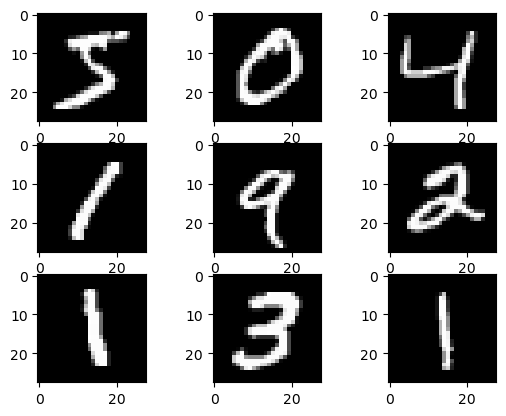

In [188]:
(trainX, trainy), (testX, testy) = mnist.load_data()
# Посмотрим, что там
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# Выведем первые несколько изображений
for i in range(9):
    plt.subplot(330 + 1 + i)
    # Покажем пиксети как есть
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

plt.show()

Основные операции, такие как загрузка данных, масштабирование и построение модели оформим в виде функций.

In [189]:
# Загрузка набора данных
def load_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # Меняем форму, чтобы набор был одноканальным
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # применяем унитарное кодирование к размеченным выходам
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [190]:
# Масштабирование
def prep_pixels(train, test):
    # Конвертируем в вещественные значения
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # Приводим яркости к диапазону [0; 1]
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm

In [191]:
# Построение модели CNN
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [192]:
model = define_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               540900    
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


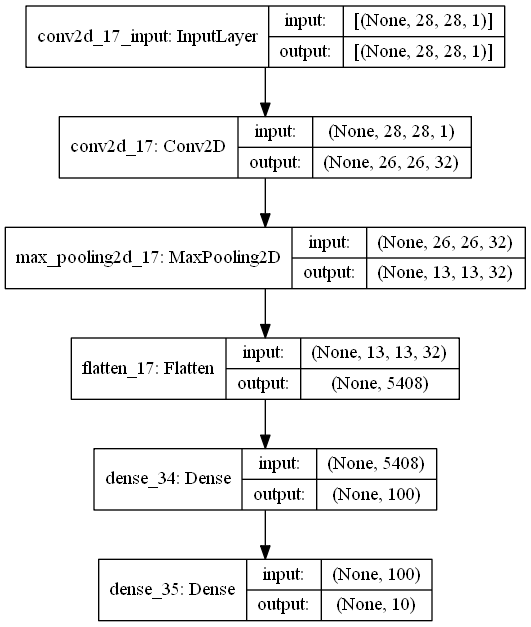

In [193]:
#визуализация модели
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [194]:
# Построим и оценим модель, используя k-fold кросс-валидацию
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # Настраиваем кросс-валидацию
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # Обходим все разбиения
    for train_ix, test_ix in kfold.split(dataX):
        # Строим модель
        model = define_model()
        # Получаем данные для обучающей и проверочной выборки
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # Учим модель - это не очень быстро на старых ПК, но за несколько минут отработает
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # Оцениваем модель
        _, acc = model.evaluate(testX, testY, verbose=1)
        print('> %.3f' % (acc * 100.0))
        # Сохраняем статистику - пригодится для построения графиков
        scores.append(acc)
        histories.append(history)
        
    return scores, histories

In [195]:
# Строим кривые обучения для диагностики
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [196]:
# Подбиваем итоги по результатам
def summarize_performance(scores):
    # Выводим статистику
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # Строим графики (коробочный график и "усы")
    plt.boxplot(scores)
    plt.show()

375/375 [==============================] - 1s 3ms/step - loss: 0.0599 - accuracy: 0.9857
> 98.567
375/375 [==============================] - 1s 3ms/step - loss: 0.0534 - accuracy: 0.9862
> 98.617
375/375 [==============================] - 1s 3ms/step - loss: 0.0514 - accuracy: 0.9873
> 98.733
375/375 [==============================] - 1s 3ms/step - loss: 0.0430 - accuracy: 0.9879
> 98.792
375/375 [==============================] - 1s 3ms/step - loss: 0.0515 - accuracy: 0.9877
> 98.767


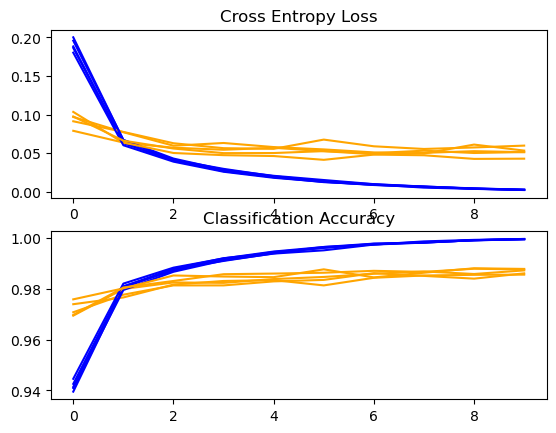

Accuracy: mean=98.695 std=0.088, n=5


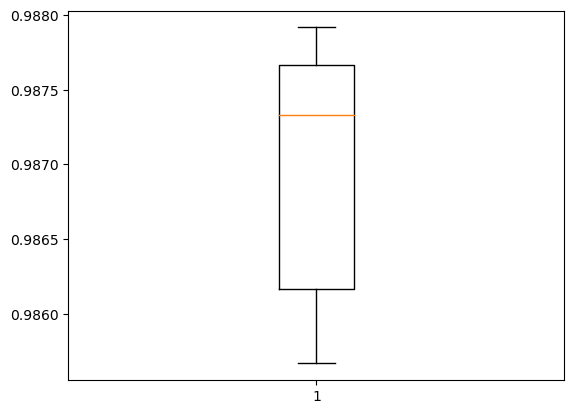

In [197]:
# Запускаем процесс - это главная функция
def run():
    # Грузим данные
    trainX, trainY, testX, testY = load_dataset()
    # Нормализуем изображения для Tensorflow и нейросети
    trainX, testX = prep_pixels(trainX, testX)
    # Строим и оцениваем модель
    scores, histories = evaluate_model(trainX, trainY)
    # Строим кривые обучения
    summarize_diagnostics(histories)
    # Считаем агрегированную статистику
    summarize_performance(scores)
 

# Точка входа - 3... 2... 1... Поехали!
run()

Получен неплохой результат, но его можно улучшить. Вам предлагается задание, в котором это можно сделать самостоятельно.

## <span style="color: #f0f">Задание 2</span>

Считаем построенную модель базовой (baseline). Теперь давайте улучшим её и выжмем столько точности, сколько получится.

1. Усовершенствуйте данную модель, добавив слой батч-нормализации. Оцените изменение результата.
2. Увеличьте размеры карт активации модели в несколько раз. Переобучите модель. Оцените изменение результата. Что можно сказать о такой модели, судя из кривых обучения?
3. Увеличьте глубину модели и переобучите её. Оцените изменение результата.

Найдите модель, которая устойчиво даёт точность классификации более 99% и при этом не является слишком большой.